# Гусев Яромир ПМ22-6

# Машинное обучение в задачах идентификации личности по изображению

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from PIL import Image
from tqdm import tqdm, trange

In [4]:
f = open('celebA_500/celebA_anno.txt')
lines = f.readlines()
dict1 = dict()
for i in range(0,500):
    dict1[i] = []
for i in lines:
    z = i.split()
    dict1[int(z[1])].append(z[0])

a = {1:[2,3]}
names = [dict1[i] for i in dict1]
cnts = [len(dict1[i]) for i in dict1]
df = pd.DataFrame({'images':names,'img_counts':cnts})
df

,images,img_counts
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
498,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


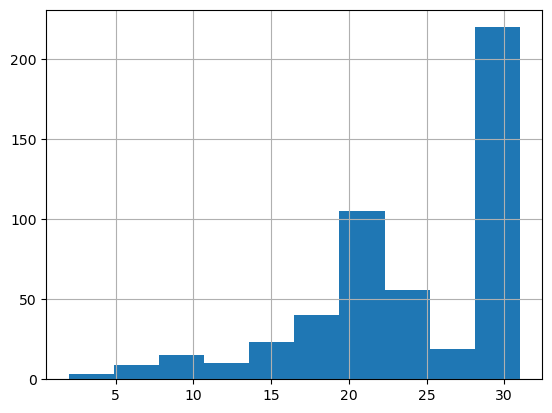

In [5]:
df['img_counts'].hist();

In [37]:
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames


folder = 'celebA_500/celebA_imgs'
images, filenames = load_images_from_folder(folder)

100%|██████████████████████████████████████████████████████████████████████████| 23948/23948 [00:22<00:00, 1086.11it/s]


In [36]:
def extract_features(images):
    all_features = []
    
    for img in tqdm(images):
        hist_features = []
        for i in range(3):  # Для каждого канала цвета
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_features.extend(hist.flatten())
        
        # HOG features
#         fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
#                             cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        
#         LBP features
        lbp = local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize
        
#         Статистические признаки
        mean = np.mean(img, axis=(0, 1))
        std = np.std(img, axis=(0, 1))
        max_ = np.max(img, axis=(0, 1))
        min_ = np.min(img, axis=(0, 1))
        
        # Объединение признаков
        combined_features = np.hstack([
            hist_features,
#             fd,
            lbp_hist,
            mean,
            std,
            max_,
            min_
        ])
        all_features.append(combined_features)
        
    features_df = pd.DataFrame(all_features)
    
    return features_df

X = extract_features(images)

 10%|███████▊                                                                     | 2437/23948 [00:29<04:19, 82.84it/s]


KeyboardInterrupt: 

In [38]:
500*30

15000